## Data quality check / cleaning / preparation 

Data cleaning and preparation has been conducted, and the cleaned train and test datasets are imported as X_train_tree, y_train_tree, X_test_tree, and y_test_tree below. 

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split, KFold, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score,roc_curve,auc,precision_recall_curve, accuracy_score, \
recall_score, precision_score, confusion_matrix
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it

In [43]:
#importing the data with the selected 22 predictors
X_train = pd.read_csv('X_train_tree.csv')
y_train = pd.read_csv('y_train_tree.csv')
X_test = pd.read_csv('X_test_tree.csv')
y_test = pd.read_csv('y_test_tree.csv')
X_train = X_train.set_index('Unnamed: 0')
y_train = y_train.set_index('Unnamed: 0')
X_test = X_test.set_index('Unnamed: 0')
y_test = y_test.set_index('Unnamed: 0')

# Exploratory data analysis

In [3]:
X_train.columns
train = pd.concat([X_train, y_train], axis=1)
train.shape

(57226, 23)

In [4]:
#correlating
corr = X_train.corrwith(train.y).sort_values(ascending = False)
corr[abs(corr)>0.1]

HETENURE    0.215588
HRHTYPE     0.109338
HEFAMINC   -0.382936
dtype: float64

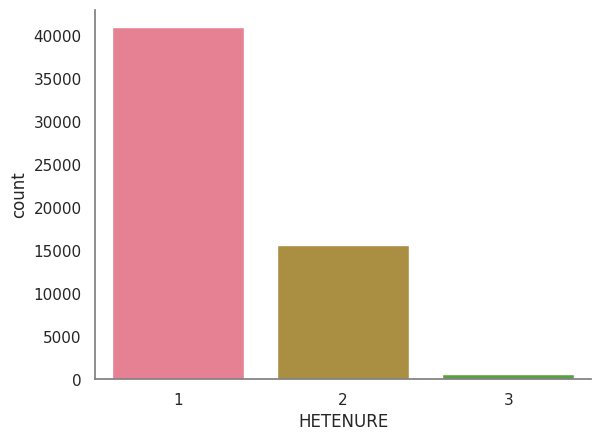

In [5]:
#cash rent vs not cash rent
#1 = OWNED OR BEING BOUGHT BY A HOUSEHOLD MEMBER
train = pd.concat([X_train, y_train], axis=1)
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="HETENURE")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

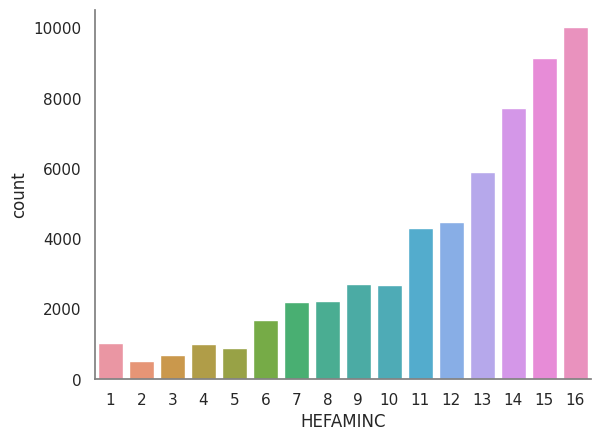

In [6]:
#family income, low to high
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="HEFAMINC")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

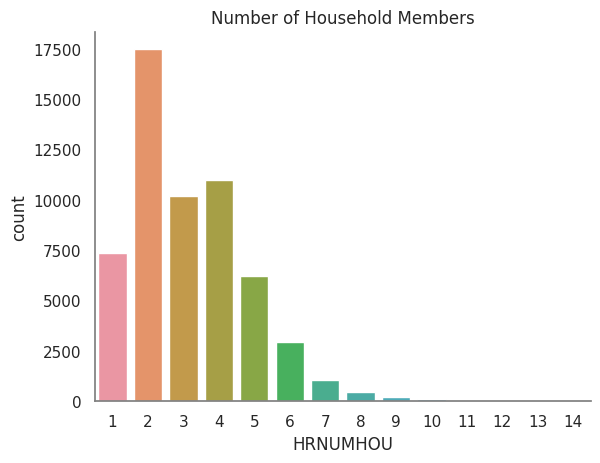

In [7]:
#number of people in the household
plt.title('Number of Household Members')
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="HRNUMHOU")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

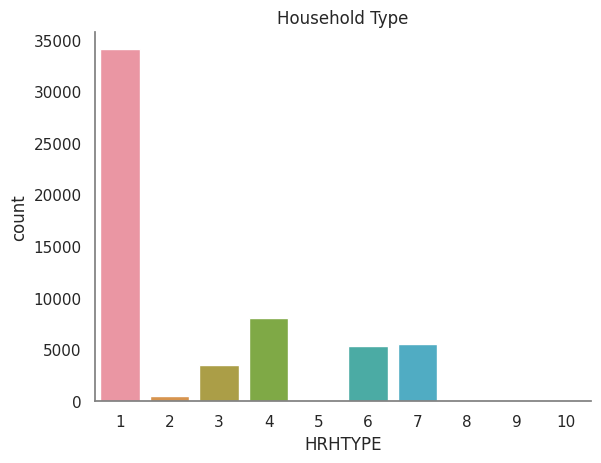

In [8]:
#household type
plt.title('Household Type')

sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="HRHTYPE")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

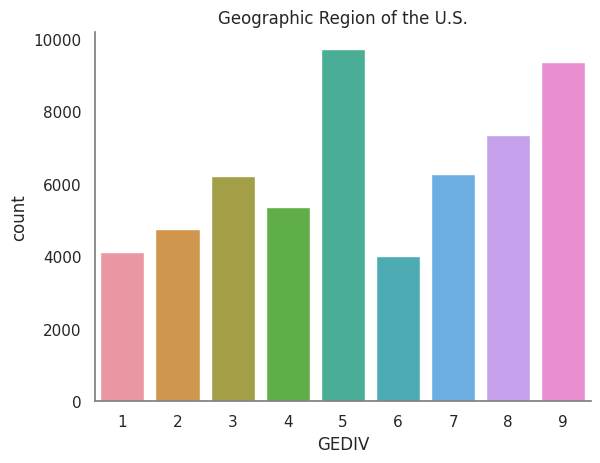

In [9]:
#geographic region
plt.title('Geographic Region of the U.S.')
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="GEDIV")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

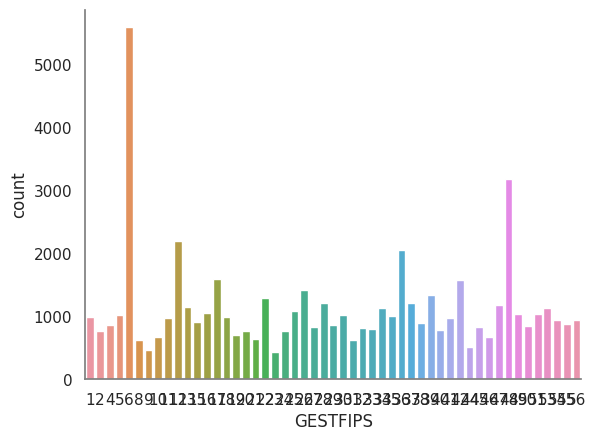

In [10]:
#States
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="GESTFIPS")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

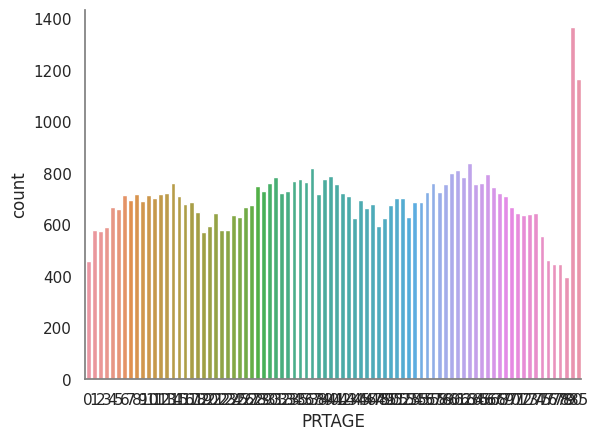

In [12]:
#age of interiewee
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="PRTAGE")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

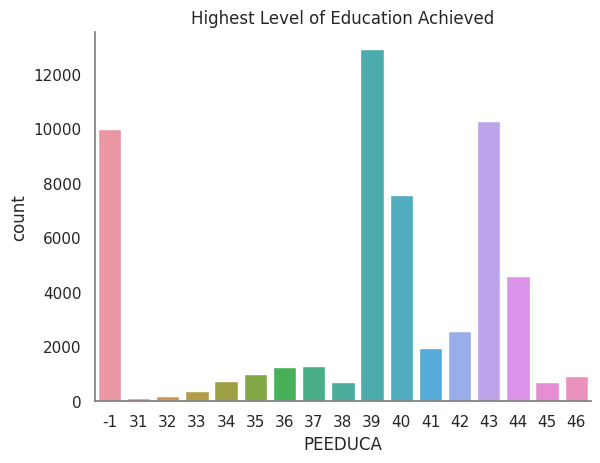

In [13]:
#highest level of education achieved
plt.title('Highest Level of Education Achieved')
sns.set(style="white")
sns.set_palette("husl")
ax = sns.countplot(data=X_train, x="PEEDUCA")
ax.spines['bottom'].set_color('grey')
ax.spines['left'].set_color('grey')
sns.despine()

# Model Development: AdaBoost

Base AdaBoost Model:

In [14]:
model = AdaBoostClassifier(random_state=1).fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  83.5115677640316
ROC-AUC:  0.8282175593572441
Precision:  0.5710659898477157
Recall:  0.2671151563118322


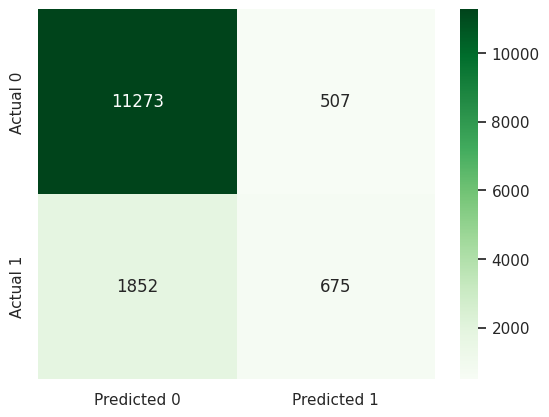

In [15]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_test, y_pred))
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Accuracy: 83.51% <br>
Recall: 26.71%

In [19]:
model.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': 'deprecated',
 'estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 1}

Tuning Hyperparameters: Coarse Search

In [20]:
#Adaboost attempt
model = AdaBoostClassifier(random_state=1, base_estimator = DecisionTreeClassifier(random_state=1))
grid = dict()
grid['n_estimators'] = [100,200,500,700,1000]
grid['learning_rate'] = [0.0001,0.001, 0.01,0.1]
grid['base_estimator__max_depth'] = [11,15,19]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 2 folds for each of 60 candidates, totalling 120 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best: 0.914235 using {'base_estimator__max_depth': 15, 'learning_rate': 0.01, 'n_estimators': 1000}


In [27]:
params_df = pd.DataFrame(params)

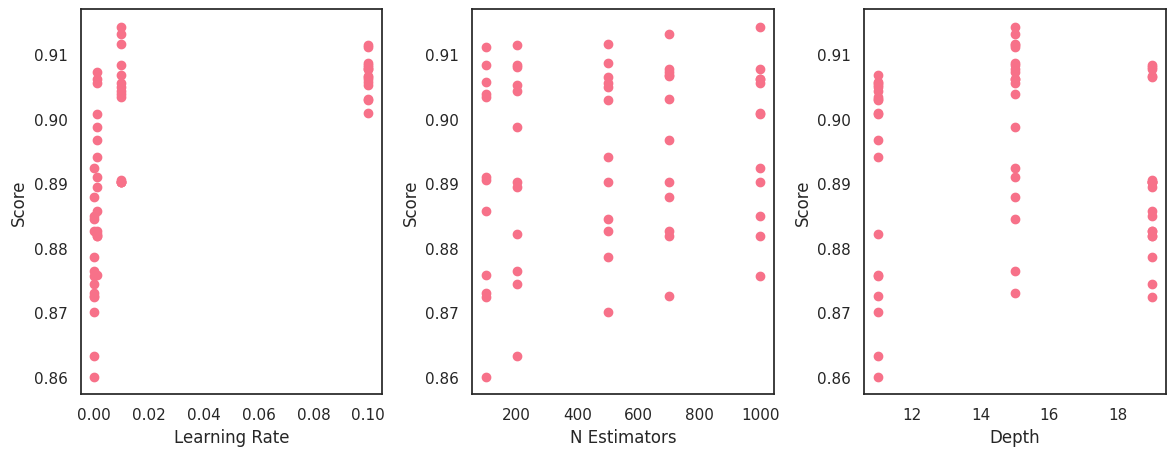

In [26]:
#visualizing the results
#visualizing the results
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.3)
axes[0].plot(params_df.iloc[:,1], means, 'o')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Score')

axes[1].plot(params_df.iloc[:,2], means, 'o')
axes[1].set_xlabel('N Estimators')
axes[1].set_ylabel('Score');

axes[2].plot(params_df.iloc[:,0], means, 'o')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Score');

In [28]:
model_1 = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=15),learning_rate=0.01,
                          n_estimators=1000).fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  94.49919619766548
Recall:  0.7340720221606648


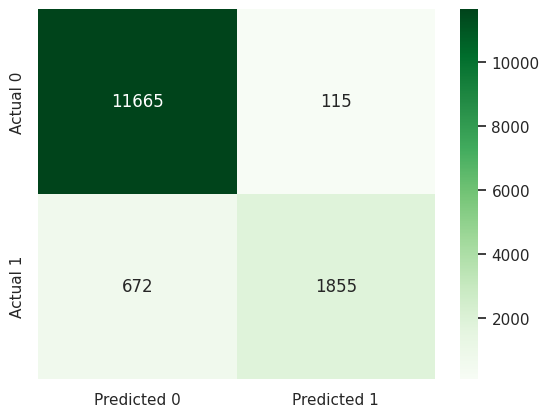

In [30]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model_1.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Tuning Hyperparameters: Finer Search

In [31]:
model = AdaBoostClassifier(random_state=1, base_estimator = DecisionTreeClassifier(random_state=1))

grid = dict()
grid['n_estimators'] = [700,1000,1100]
grid['learning_rate'] = [0.008,0.01,0.02]
grid['base_estimator__max_depth'] = [16]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True)
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Best: 0.912470 using {'base_estimator__max_depth': 16, 'learning_rate': 0.02, 'n_estimators': 700}


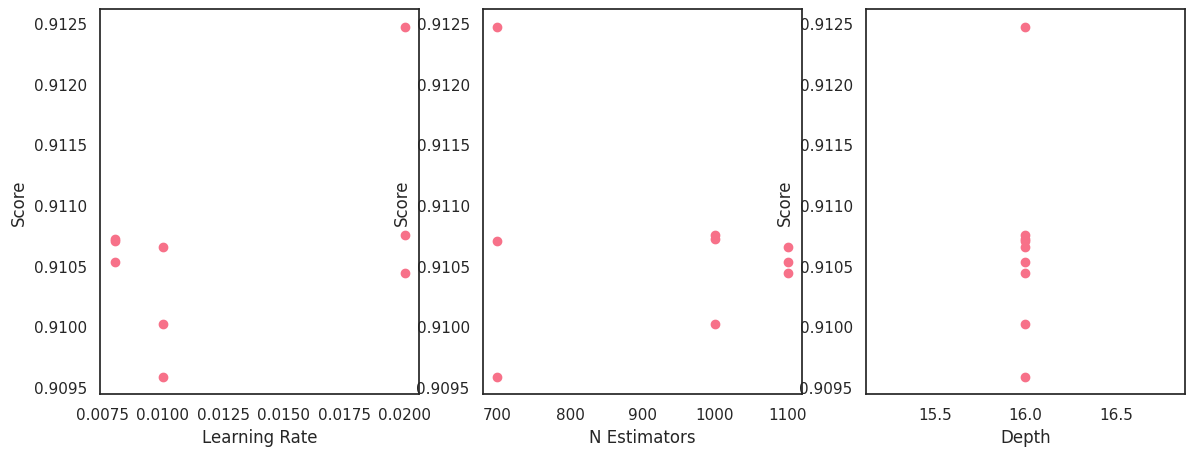

In [32]:
#visualizing the results
fig, axes = plt.subplots(1,3,figsize=(14,5))
plt.subplots_adjust(wspace=0.2)
axes[0].plot(pd.DataFrame(params).iloc[:,1], means, 'o')
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Score')

axes[1].plot(pd.DataFrame(params).iloc[:,2], means, 'o')
axes[1].set_xlabel('N Estimators')
axes[1].set_ylabel('Score');

axes[2].plot(pd.DataFrame(params).iloc[:,0], means, 'o')
axes[2].set_xlabel('Depth')
axes[2].set_ylabel('Score');

In [33]:
model_2 = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=16),learning_rate=0.02,
                          n_estimators=700).fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  95.19116516390578
Recall:  0.7708745548080728


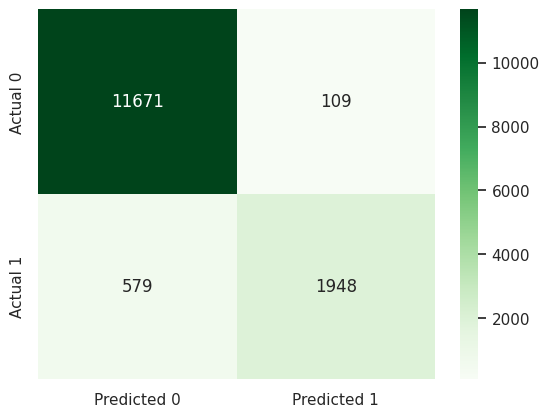

In [34]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model_2.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Accuracy: 95.19% <br>
Recall:  77.1%

Model 3 (Random)

In [35]:
model_3 = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=15),learning_rate=0.01,
                          n_estimators=200).fit(X_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  94.58307122387643
Recall:  0.7641472101305896


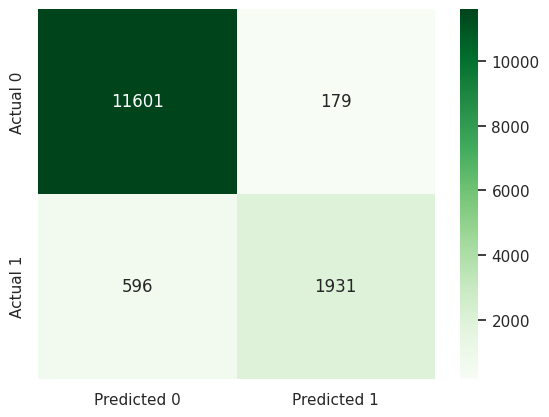

In [36]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.5

y_pred_prob = model_3.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Tuning Decision Threshold Probability

In [46]:
#preparing y_train
y_train = np.ravel(y_train)
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [47]:
# KFold probabilities
cross_val_prob = cross_val_predict(model_2, X_train, y_train, method = 'predict_proba', n_jobs = -1, cv = 5)

# Getting p, r, thresholds, (by function) and accuracies (by for loop) 
p, r, thresholds = precision_recall_curve(y_train, cross_val_prob[:,1])

accuracies = []

for threshold in thresholds:
    predicted_class = cross_val_prob[:,1] > threshold
    predicted_class = predicted_class.astype(int)
    
    #Computing optimals
    accuracies = accuracies + [accuracy_score(y_train, predicted_class)]

In [49]:
len(accuracies)

57062

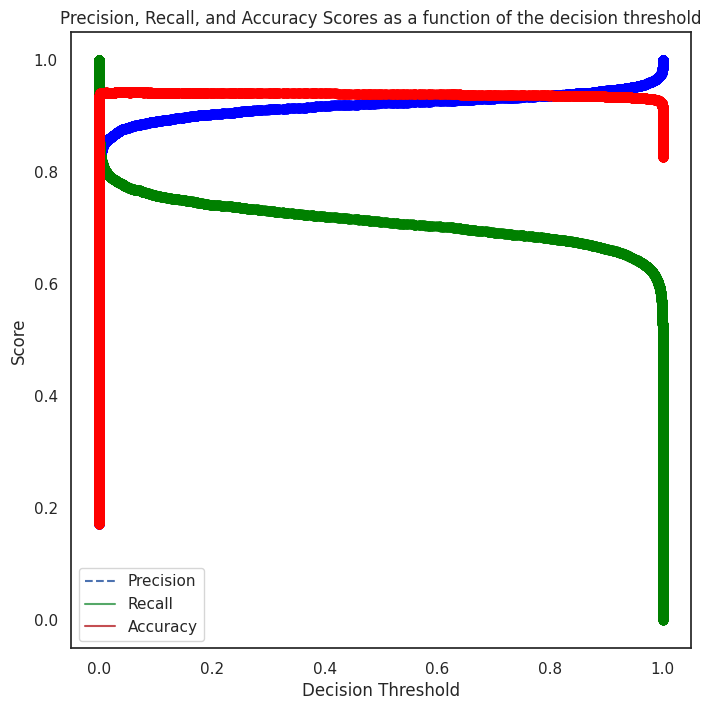

In [50]:
# Plotting function
def plot_precision_recall_vs_threshold(precisions, recalls, accuracies, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision, Recall, and Accuracy Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracies, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, accuracies, "o", color = 'red')
    plt.plot
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, accuracies, thresholds)

In [60]:
# Testing thresholds
metrics_iter = pd.DataFrame(columns = ['threshold', 'recall', 'accuracy'])
threshold_hyperparam_vals = np.arange(0.0, 0.2, 0.001)
iter_number = 0

for threshold_prob in threshold_hyperparam_vals:
    predicted_class = cross_val_prob[:,1] > threshold_prob
    predicted_class = predicted_class.astype(int)
    
    #Computing optimals
    accuracy = accuracy_score(y_train, predicted_class)
    recall = recall_score(y_train, predicted_class)
    metrics_iter.loc[iter_number, 'threshold'] = threshold_prob
    metrics_iter.loc[iter_number, 'recall'] = recall
    metrics_iter.loc[iter_number, 'accuracy'] = accuracy
    iter_number = iter_number + 1

In [61]:
a = metrics_iter[metrics_iter.accuracy >= 0.90]
a[a.recall >= 0.73]

,threshold,recall,accuracy
1,0.001,0.843048,0.93842
2,0.002,0.832321,0.940621
3,0.003,0.825339,0.941355
4,0.004,0.820482,0.941635
5,0.005,0.817345,0.941932
...,...,...,...
195,0.195,0.74236,0.941722
196,0.196,0.742259,0.941705
197,0.197,0.742259,0.94174
198,0.198,0.742259,0.941775


Not really sure what to make of this...

Model Performance With Tuned Threshold

Accuracy:  95.37289438736283
Recall:  0.8056984566679858


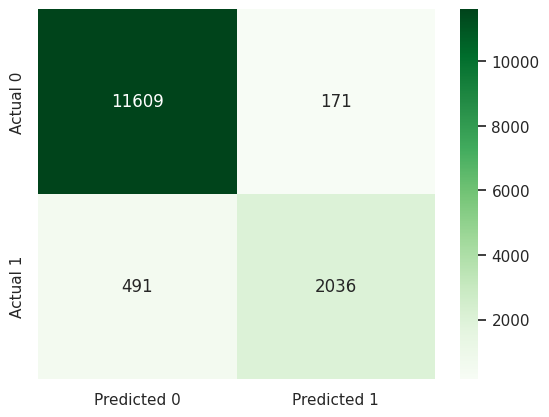

In [67]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.1

y_pred_prob = model_2.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Outlier Detection

In [68]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.0001, n_jobs = -1)
yhat = iso.fit_predict(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [69]:
mask = yhat != -1
X_train_noout, y_train_noout = X_train.loc[mask, :], y_train[mask]

In [71]:
model = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=16),learning_rate=0.02,
                          n_estimators=700).fit(X_train_noout,y_train_noout)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  95.63849863703082
Recall:  0.817174515235457


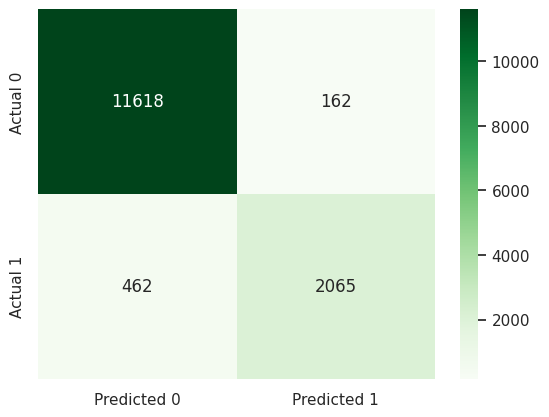

In [72]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.1

y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

Tuning Outlier Detection Threshold

In [ ]:
iso = IsolationForest(contamination=0.0001, n_jobs = -1)
yhat = iso.fit_predict(X_train)

mask = yhat != -1
X_train_noout, y_train_noout = X_train.loc[mask, :], y_train[mask]

model = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=16),learning_rate=0.02,
                          n_estimators=700).fit(X_train_noout,y_train_noout)

In [76]:
contaminations = [0.0001, 0.001, 0.01, 0.1]
accuracy_scores = []
for c in contaminations:
  iso = IsolationForest(contamination=c, n_jobs = -1)
  yhat = iso.fit_predict(X_train)

  mask = yhat != -1
  X_train_noout, y_train_noout = X_train.loc[mask, :], y_train[mask]

  # Defining the evaluation procedure
  cv = KFold(n_splits = 2, shuffle = True)
  # Defining the grid search procedure
  model = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=16),learning_rate=0.02,
                          n_estimators=700)
  cv_score = cross_val_score(model, X_train_noout, y_train_noout, cv = cv, scoring = 'accuracy')
  accuracy_scores.append(cv_score.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: Fut

In [77]:
accuracy_scores

[0.9105033205173017, 0.9156171284634761, 0.9149206211664977, 0.910510018708696]

Optimal contamination parameter = 0.001

In [79]:
iso = IsolationForest(contamination=0.001, n_jobs = -1)
yhat = iso.fit_predict(X_train)

mask = yhat != -1
X_train_noout, y_train_noout = X_train.loc[mask, :], y_train[mask]

model_lila = AdaBoostClassifier(random_state=1,base_estimator = DecisionTreeClassifier(max_depth=16),learning_rate=0.02,
                          n_estimators=700).fit(X_train_noout,y_train_noout)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy:  95.3798839728804
Recall:  0.8025326474079937


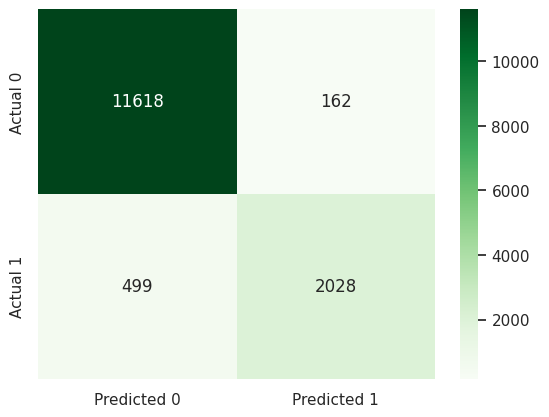

In [80]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.1

y_pred_prob = model_lila.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_test)*100)  

#Computing recall
print("Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Greens', fmt='g');

**Final Model Accuracy:** 95.64% <br>
**Final Model Recall:** 81.72% <br>
(as seen in the second-to-last classification matrix)